In [1]:
%%bash
rm -r sample_data/
git clone https://github.com/gitUmaru/SSITAC.git
find ./SSITAC/ -maxdepth 1 -mindepth 1 -exec mv {} . \;
rm -r ./SSITAC/

Cloning into 'SSITAC'...


In [2]:
## Gen data file struct
!python ./data/split.py

100% 57/57 [00:00<00:00, 685.05it/s]


In [1]:
import tensorflow as tf
import numpy as np
from keras.models import Model, Sequential
from keras.layers import *
from keras import backend
from keras.optimizers import Adam
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

from warnings import filterwarnings

In [2]:
# CONSTANTS

EPOCHS = 5
TRAIN_IM_PATH = "./data/dataset/train_im/"
TRAIN_MA_PATH = "./data/dataset/train_ma/"

TEST_IM_PATH = "./data/dataset/test_im/"
TEST_MA_PATH = "./data/dataset/test_ma/"

In [32]:
def load_data():
  train_im = sorted(glob.glob(TRAIN_IM_PATH+f'*.jpg'))
  train_im_arr = np.array([np.array(Image.open(fname)) for fname in train_im])

  train_ma = sorted(glob.glob(TRAIN_MA_PATH+f'*.jpg'))
  train_ma_arr = np.array([np.array(Image.open(fname)) for fname in train_ma])

  test_im = sorted(glob.glob(TEST_IM_PATH+f'*.jpg'))
  test_im_arr = np.array([np.array(Image.open(fname)) for fname in test_im])

  test_ma = sorted(glob.glob(TEST_MA_PATH+f'*.jpg'))
  test_ma_arr = np.array([np.array(Image.open(fname)) for fname in test_ma])

  def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)
    
  train_im_resized = []
  train_ma_resized = []
  test_im_resized = []
  test_ma_resized = []

  for i in range(len(train_im)):
      train_im_resized.append(resize(train_im[i]))
      train_ma_resized.append(resize(train_ma[i]))
  for i in range(len(test_im)):
      test_im_resized.append(resize(test_im[i]))
      test_ma_resized.append(resize(test_ma[i]))

  X_train = np.array([np.array(img) for img in train_im_resized])
  Y_train = np.array([np.array(img) for img in train_ma_resized])

  X_test = np.array([np.array(img) for img in test_im_resized])
  Y_test = np.array([np.array(img) for img in test_ma_resized])

  return (X_train, Y_train), (X_test, Y_test)

In [36]:
(x_train, y_train), (x_test, y_test) = load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

y = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


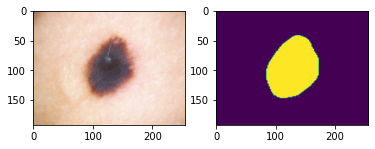

In [37]:
index = random.randint(1,len(x_train)-1)
fig, ax = plt.subplots(1,2)
ax[0].imshow(x_train[index])
ax[1].imshow(y_train[index])

In [41]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return np.array(x_image), np.array(y_image.astype('int'))

In [43]:
def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [50]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []

    x_flip = []
    y_flip = []

    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [51]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

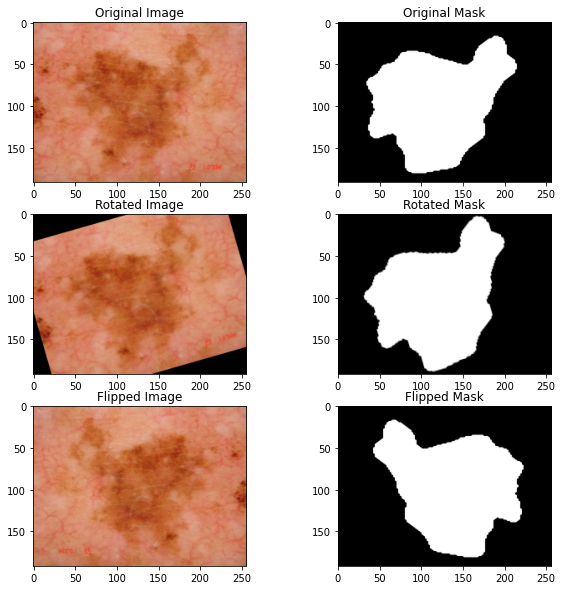

In [61]:
index = random.randint(1,len(x_train)-1)

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(x_train[img_num])
ax[0,0].set_title('Original Image')
ax[0,1].imshow(y_train[img_num], plt.cm.binary_r)
ax[0,1].set_title('Original Mask')
ax[1,0].imshow(x_rotated[img_num])
ax[1,0].set_title('Rotated Image')
ax[1,1].imshow(y_rotated[img_num], plt.cm.binary_r)
ax[1,1].set_title('Rotated Mask')
ax[2,0].imshow(x_flipped[img_num])
ax[2,0].set_title('Flipped Image')
ax[2,1].imshow(y_flipped[img_num], plt.cm.binary_r)
ax[2,1].set_title('Flipped Mask')
plt.show()

In [62]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])